In [ ]:
import numpy as np
import sys
import pathlib
import os
import importlib.util

# Optional TensorFlow import with graceful NumPy fallback
try:  # Try real TensorFlow first
    import tensorflow as tf  # type: ignore
    _USING_REAL_TF = True
except Exception:  # Fallback shim
    _USING_REAL_TF = False
    class _TFShim:
        float32 = np.float32
        def convert_to_tensor(self, x, dtype=None):
            return np.array(x, dtype=dtype if dtype is not None else None)
        def transpose(self, x, perm=None):
            return np.transpose(x, axes=perm)
        def sign(self, x):
            return np.sign(x)
        def einsum(self, subscripts, *operands, **kwargs):
            return np.einsum(subscripts, *operands, **kwargs)
        def expand_dims(self, a, axis):
            return np.expand_dims(a, axis=axis)
        def reshape(self, a, shape):
            return np.reshape(a, shape)
    tf = _TFShim()  # type: ignore
    print("[shim] TensorFlow not found; using NumPy compatibility shim.")

# Absolute project directory where this notebook and Networks.py reside
expected_dir = pathlib.Path(r"C:/Users/ladia/Desktop/TAMFed/UNSUP").resolve()
if pathlib.Path.cwd().resolve() != expected_dir:
    os.chdir(expected_dir)
    print(f"[cwd] Changed working directory to {expected_dir}")

# Ensure project dir is on sys.path (front preferred for local overrides)
if str(expected_dir) not in sys.path:
    sys.path.insert(0, str(expected_dir))

networks_file = expected_dir / "Networks.py"
if not networks_file.exists():
    raise FileNotFoundError(f"Expected Networks.py at {networks_file} but it was not found. Directory contents: {list(expected_dir.iterdir())}")

# Try normal import first, then fallback to manual loading
try:
    from Networks import Hopfield_Network, TAM_Network  # core classes
except ModuleNotFoundError as e:
    print("[import] Standard import failed, attempting manual spec load.")
    spec = importlib.util.spec_from_file_location("Networks", str(networks_file))
    if spec is None or spec.loader is None:
        raise RuntimeError(f"Cannot build spec for Networks.py at {networks_file}: {e}")
    Networks_mod = importlib.util.module_from_spec(spec)
    sys.modules["Networks"] = Networks_mod
    spec.loader.exec_module(Networks_mod)  # type: ignore
    # Extract required symbols
    try:
        Hopfield_Network = getattr(Networks_mod, "Hopfield_Network")
        TAM_Network = getattr(Networks_mod, "TAM_Network")
    except AttributeError as e2:
        raise RuntimeError(f"Networks.py loaded but missing expected classes: {e2}")
    print(f"[import] Loaded Networks.py manually from {networks_file}")

# Import utility functions
from Functions import *  # wildcard kept for existing notebook references

import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.linalg import null_space

# Quick sanity check (avoids silent import issues)
if 'Hopfield_Network' not in globals() or 'TAM_Network' not in globals():
    raise RuntimeError("Core network classes not loaded correctly.")
print(f"[import] Hopfield_Network, TAM_Network ready. Project dir: {expected_dir} (TF real: {_USING_REAL_TF})")

***
# Piccolo SPIEGONE

L'idea è partire da una rete fatta da due client è un server. 

I Client hanno ognuno un batch di dati del tipo: $\{\eta_i^{\mu, b, (l)}\}_{i=1,\cdots,N}^{(\mu = 1, \cdots, K), (b=1,\cdots, M)}$ e dove $(l)=1,\cdots, L$ distingue i client.

In ogni round abbiamo a disposizione degli $M$ esempi totali solo una frazione $B = M // (\#round)$ avendo quindi un ulteriore divisione del dataset del tipo
$$\{\eta_i^{\mu, b, m, (l)}\}_{i=1,\cdots,N}^{(\mu = 1, \cdots, K), (b=1,\cdots, B), (m=1, \cdots, \# round)}$$

ora creiamo una matrice sinaptica in modo unsupervised per ogni client del primo round
$$J_{ij}^{m=1,(l)}=\frac{1}{N B}\sum_{\mu,b=1}^{K,B}\eta_i^{\mu, b, m=1,(l)}\eta_j^{\mu,b,m=1,(l)}\;\;\;\;\mathrm{con}\;\;(a)=1,2$$

Una volta create le singole $J_{ij}^{1,(l)}$ le mergiamo in media creando la $J_{ij}^{1,(server)}$ che è la media delle precedenti e dalla quale faremo partire l'algoritmo TAM
$$J_{ij}^{1,(server)}=\frac{1}{L}\sum_{l=1}^{L}J_{ij}^{1,(l)}$$

Con la TAM estraiamo dalla $J_{ij}^{1,(server)}$ le approssimazioni degli archetipi $\{\tilde{\xi}^{\,\mu, m=1}_i\}_{i=1,\cdots,N}^{\mu=1, \cdots, K}$ che poi verranno spedite indietro ai client e faranno parte dei run successivi in una sorta di meccanismo di learning federato self supervised:

$$J_{ij}^{m=2,(l)}=w\frac{1}{N B}\sum_{\mu,b=1}^{K,B}\eta_i^{\mu, b, m=2,(l)}\eta_j^{\mu,b,m=2,(l)} + (1-w)\frac{1}{N}\sum_{\mu=1}^{K}\tilde{\xi}_i^{\mu, m=1}\tilde{\xi}_j^{\mu, m=1}$$

dove $w\in[0;1]$ è il peso che vogliamo assegnare a ogni componente. Ovviamente il processo deve essere iterato fino all'esaurimento del numero di batch, ovvero $\#round$ volte.

Quindi per esempio al 2° round
$$J_{ij}^{2,(server)}=\frac{1}{L}\sum_{l=1}^{L}J_{ij}^{m=2,(l)}=\frac{w}{LN B}\sum_{l,\mu,b=1}^{L,K,B}\eta_i^{\mu, b, m=2,(l)}\eta_j^{\mu,b,m=2,(l)} + (1-w)\frac{1}{N}\sum_{\mu=1}^{K}\tilde{\xi}_i^{\mu, m=1}\tilde{\xi}_j^{\mu, m=1}$$
***

In [ ]:
import importlib, Functions
importlib.reload(Functions)
from Functions import *  # refresh symbols including updated tf backend
print('[reload] Functions module reloaded; backend has transpose?', hasattr(tf, 'transpose'))

## Funzioni poenzialmente utili per riscalamento magnetizzazioni

per ora lasciatele perdere non le usiamo

In [ ]:
def diag_generale(result):
    # Crea una maschera che è 1 quando a == b, altrimenti 0
    k, a, b = result.shape
    mask = np.eye(a)[None, :, :]  # shape: (1, a, b)

    # Applica la maschera al tensore
    return result * mask  # broadcasting: (k, a, b) * (1, a, b)

# x = ETA_sup[0,0,:,0,:]
def r_empirico(x):
    M, K, N = x.shape
    temp = np.einsum('aki,bki->kab',x,x)/N
    return np.mean(np.sqrt(np.sum(temp - diag_generale(temp), axis=(1,2))/(M*(M-1))))

## Funzioni per creare i batch e calcolare il $K_{eff}$ 
come il numero di autovettori che hanno autovalore maggiore di una certa soglia (nel caso perfetto gli autovettori che ci interessanno dovrebbero avere tutti autovalore 1).

Ma essendo che sfruttiamo calcolo numerico e abbiamo gli esempi io metterei un cutoff molto più basso, basta assicurarsi che gli autovettori non siano 0 o vicini a 0.

In [ ]:
# function to concatenate new extracted archetypes and batches (for 0 steps only batch examples is used)
def new_round(data, round=0, collection = False):
    if not collection:
        new_data = data[:, round, :, :]
    else:
        new_data = data[:, 0, :, :]
        new_data = tf.transpose(new_data, (1, 0, 2))
        for r in range(round):
            new_data = np.vstack((new_data,  tf.transpose(data[:, r+1, :, :], (1, 0, 2))))
        new_data = tf.transpose(new_data, (1, 0, 2))
    return tf.convert_to_tensor(new_data, dtype=np.float32)


# funzione per calcolare autovettori con autovalori maggiori di un certo cutoff e relativa stima di K
def calcolo_autovett(JKS):
    vals, vecs = np.linalg.eig(JKS)
    index = np.real(vals) > 0.5
    autovett = np.real(vecs[:, index]).T  # shape (k_eff, N)
    K_eff = autovett.shape[0]
    return autovett, K_eff

## Funzione che genera gli stati spuri di partenza

Abbiamo due modi per generare gli stati spuri:

1. prendere $M_{start}$ compinazioni lineari in segno degli autovettori della matrice di KS 
2. farci dare $M_{start}$ combinazioni lineari in segno da ognuno dei client ad ogni round

In [ ]:
# creo combinazioni lineari in segno degli autovettori della matrice KS
# c'è l'opzione di utilizzare anche \xi trovati da run precedenti
def generazione_input(K_eff, autovett, L):
    M = 10*int(K_eff/L*np.log(K_eff/0.01))
    weigth = np.random.normal(0,1, size = (M, autovett.shape[0]))
    new = tf.sign(tf.einsum('ij,mi->mj',autovett , weigth))
    return new


# creo combinazioni lineari in segno (per ogni layer) degli esempi che entrano in gioco nella crazione della Jij
def comb_esempi(ETA_batch, M_expamples):
    L, M_data, N = ETA_batch.shape
    weigth = np.random.normal(0,1, size = (M_expamples, M_data, L))
    vv = tf.sign(np.sum(tf.einsum('mal, lai ->  lami', weigth, ETA_batch), axis= 1))
    return vv

## Processo di separazione

In [ ]:
# server disentangling
def disentangling(x, K, L, J_rec, JKS_iter, ξ, updates, ξr_old=-10, βT=2.5, h=0.1, λ=0.2, show_bar: bool = True):
    K_eff_tot, N = x.shape
    x=generazione_input(K, x, L)
    #L, M_ex, N = x.shape
    #x = tf.reshape(x, [L*M_ex, N])
    ### dynamics
    σr = tf.convert_to_tensor([x]*L)
    σr = np.swapaxes(σr, 0, 1)
    Net = TAM_Network()
    Net.prepare(J_rec,L)
    Net.dynamics(σr, βT, λ, h, updates=updates, show_progress=show_bar, desc="TAM round")
    ξr_new = np.reshape(Net.σ,(L*x.shape[0],N))
    if np.mean(ξr_old) != -10:
        ξr = np.vstack((ξr_new, ξr_old))
    else:
        ξr = ξr_new
    ### check eigenvectors of KS    
    temp = tf.einsum('ij,Aj->Ai',JKS_iter,ξr)
    check2 =tf.einsum('Ai,Ai->A',ξr,temp)/N

    toremove2 = (check2<0.6)
    ξr = np.delete(ξr, toremove2,axis=0)
    
    ### check
    qξr = np.abs(np.array(tf.einsum('ai,bi->ab',ξr,ξr)/N))
    qξr = np.triu(qξr,1)
    check = (qξr >0.4)
    toremove = [];
    ### controls on mutual overlap between reconstructions
    for _ in range(ξr.shape[0]):
        wh = np.where(check[_])[0]
        if len(wh)>0:
            for a in range(len(wh)):
                toremove.append(wh[a])
    ξr = np.delete(ξr, toremove,axis=0)
    
    #ms = np.zeros(K)
    ms = np.max(np.abs(tf.einsum('ai,bi->ab',ξr,ξ)/N),axis=1)
    #res.append(np.hstack((np.array([N,K_eff,x.shape[0],L,λ,βT,h]),ms)))
    return ξr, ms


def dis_check(autovett, K, L, J_rec, JKS_iter, ξ, updates=80, show_bar=True):
    K_eff, N = autovett.shape
    ξr, ms = disentangling(autovett, K, L, J_rec, JKS_iter, ξ, updates, ξr_old=-10, show_bar=show_bar)
    #print(ms)
    while len(ms) < K:
        ξr, ms = disentangling(autovett,K, L,  J_rec, JKS_iter, ξ, updates, ξr_old=ξr, show_bar=show_bar)
        print(ms)
    return ξr, ms

***

# Lancio del Codice

## Inizializzazione parametri

In [ ]:
L=3; K=4; N = 200
print("PARAMERI DELLA SIMULAZIONE: N="+str(N))
M = 2*int(K/L*np.log(K/0.01))

# generazione dei pattern (veri) e della matice di Hebb (vera)
res = [];
ξ = gen_patterns(N, K)
J = Hebb_J(ξ)

# generazione degli esempi (M_sup: numero totale di esempi; divisi in batch = n_batch; ognuno con qualità media r_ex)
M_unsup = 100
r_ex = 0.8
n_batch = 20



#ETA_sup=gen_dataset_sup_split(ξ, M_sup, r_ex, n_batch, L)
ETA_unsup=gen_dataset_unsup(ξ, M_unsup, r_ex, n_batch, L)
print(ETA_unsup.shape, M_unsup//n_batch, ETA_unsup.shape[2]//K )

## Inizio dei loop nei batch

In [ ]:
new_round(ETA_unsup, round=2, collection=False).shape, new_round(ETA_unsup, round=2, collection=True).shape

In [ ]:
# peso da dare alle componenti delle Jij
w = 1.0
# num of parallel updates TAM
up =50
J_KS_real = JK_real(ξ)
diz = {}

# Enable alternative K_eff estimation (shuffle null) & MP (preferred)
use_shuffle_keff = True
use_mp_keff = True  # new flag (MP becomes primary for decision)
shuffle_alpha = 0.01
shuffle_random = 32

show_tam_bars = True  # toggle progress bars for TAM dynamics

fro_history = []  # store per-round norms (single + extend)

# Build run-specific results directory named after hyperparameters
from pathlib import Path
run_id = f"L{L}_K{K}_N{N}_w{w}_up{up}_nb{n_batch}_M{M_unsup}_rex{r_ex}"
results_root = Path('results')
run_dir = results_root / run_id
run_dir.mkdir(parents=True, exist_ok=True)
round_log_path = run_dir / 'round_metrics.jsonl'

import json

# Helper to compute per-layer unsupervised J and mean across clients with correct M_eff
def _mean_unsup_J_per_layer(tensor_L_M_N, K):
    # tensor shape: (L, M_eff_actual, N)
    L_loc, M_eff_actual, N_loc = tensor_L_M_N.shape
    # M passed to unsupervised_J should match effective examples per archetype (assumed M_eff_actual//K)
    M_eff_param = max(1, M_eff_actual // K)
    Js = [unsupervised_J(tensor_L_M_N[l], M_eff_param) for l in range(L_loc)]  # each already / (N*M_eff_param)
    J_mean = np.sum(Js, axis=0) / L_loc  # explicit mean across clients
    return J_mean, M_eff_param

ξr = None  # will hold latest reconstructed archetypes (single branch) used for Hebbian mixing

for b in range(n_batch):
    # preparo gli esempi UNSUPERVISED appartenenti solo al b-esimo batch
    ETA_round = new_round(ETA_unsup, round=b, collection=False)  # (L, M_round, N)
    # preparo gli esempi UNSUPERVISED appartenenti ai batch dallo 0 al b-esimo
    ETA_extend = new_round(ETA_unsup, round=b, collection=True)  # (L, M_cumulative, N)

    # --- Unsupervised mean J matrices (single batch vs cumulative) ---
    J_unsup_single_mean, M_eff_round = _mean_unsup_J_per_layer(ETA_round, K)
    J_unsup_extend_mean, M_eff_extend = _mean_unsup_J_per_layer(ETA_extend, K)

    if b == 0:
        # Total (all batches upfront) for reference ONLY (we will override diz['total'] at the end to match final extend)
        ETA_extend_tot = new_round(ETA_unsup, round=n_batch-1, collection=True)
        J_unsup_extend_tot_mean, M_eff_tot = _mean_unsup_J_per_layer(ETA_extend_tot, K)

        # Initial reconstructions use purely unsupervised cumulative/all-batches J
        J_rec = J_unsup_single_mean.copy()
        J_rec_extend = J_unsup_extend_mean.copy()
        J_rec_extend_tot = J_unsup_extend_tot_mean.copy()
    else:
        if ξr is None:
            raise RuntimeError("ξr not set after first round TAM extraction.")
        # Hebbian from previously reconstructed archetypes
        J_hebb_prev = unsupervised_J(tf.convert_to_tensor(ξr, dtype=tf.float32), 1)  # (1/N) Σ ξ^μ ξ^μ
        # Weighted blend (apply w at this stage, not earlier, so extend still differs when w>0)
        J_rec = w * J_unsup_single_mean + (1 - w) * J_hebb_prev
        J_rec_extend = w * J_unsup_extend_mean + (1 - w) * J_hebb_prev

    # --- Propagate J to JK space ---
    JKS_iter = propagate_J(J_rec, iters=1, verbose=False)
    JKS_iter_extend = propagate_J(J_rec_extend, iters=1, verbose=False)

    # Eigenvectors simple cutoff (>0.5) legacy
    def _eig_cut(JK):
        vals, vecs = np.linalg.eig(JK)
        mask = (np.real(vals) > 0.5)
        autov = np.real(vecs[:, mask]).T
        return autov, autov.shape[0]

    autovett, K_eff_cutoff_single = _eig_cut(JKS_iter)
    autovett_extend, K_eff_cutoff_extend = _eig_cut(JKS_iter_extend)

    # MP-based K_eff (preferred)
    if use_mp_keff:
        try:
            K_eff_mp_single, keep_mask_mp_single, info_mp_single = estimate_K_eff_from_J(
                JKS_iter, method='mp', M_eff=M_eff_round)
        except Exception as e:
            K_eff_mp_single, keep_mask_mp_single, info_mp_single = K_eff_cutoff_single, None, {'error': str(e), 'method': 'fallback_cutoff'}
        try:
            K_eff_mp_extend, keep_mask_mp_extend, info_mp_extend = estimate_K_eff_from_J(
                JKS_iter_extend, method='mp', M_eff=M_eff_extend)
        except Exception as e:
            K_eff_mp_extend, keep_mask_mp_extend, info_mp_extend = K_eff_cutoff_extend, None, {'error': str(e), 'method': 'fallback_cutoff'}
    else:
        K_eff_mp_single, K_eff_mp_extend = K_eff_cutoff_single, K_eff_cutoff_extend
        keep_mask_mp_single = keep_mask_mp_extend = None
        info_mp_single = info_mp_extend = {'method': 'disabled'}

    # Shuffle-based (sanity) K_eff
    if use_shuffle_keff:
        K_eff_shuffle_single, keep_mask_shuf_single, info_shuf_single = estimate_K_eff_from_J(
            JKS_iter, method='shuffle', alpha=shuffle_alpha, n_random=shuffle_random)
        K_eff_shuffle_extend, keep_mask_shuf_extend, info_shuf_extend = estimate_K_eff_from_J(
            JKS_iter_extend, method='shuffle', alpha=shuffle_alpha, n_random=shuffle_random)
    else:
        K_eff_shuffle_single = K_eff_shuffle_extend = -1
        keep_mask_shuf_single = keep_mask_shuf_extend = None
        info_shuf_single = info_shuf_extend = {'method': 'disabled'}

    # TAM disentangling (use cutoff eigenvectors as basis as before)
    ξr_extend, Magn_extend = dis_check(autovett_extend, K, L, J_rec_extend, JKS_iter_extend, ξ=ξ, updates=up, show_bar=show_tam_bars)
    ξr_single, Magn_single = dis_check(autovett, K, L, J_rec, JKS_iter, ξ=ξ, updates=up, show_bar=show_tam_bars)
    ξr = ξr_single  # update reference archetypes for next round blend

    # Frobenius norms vs true JK
    fro_single = np.linalg.norm(JKS_iter - J_KS_real, ord='fro')
    fro_extend = np.linalg.norm(JKS_iter_extend - J_KS_real, ord='fro')
    fro_history.append({'round': b, 'single': fro_single, 'extend': fro_extend})

    # Append per-round JSONL metrics (MP preferred)
    round_entry = {
        'round': int(b),
        'M_eff_round': int(M_eff_round),
        'M_eff_extend': int(M_eff_extend),
        'K_eff_cutoff_single': int(K_eff_cutoff_single),
        'K_eff_mp_single': int(K_eff_mp_single),
        'K_eff_shuffle_single': int(K_eff_shuffle_single),
        'K_eff_cutoff_extend': int(K_eff_cutoff_extend),
        'K_eff_mp_extend': int(K_eff_mp_extend),
        'K_eff_shuffle_extend': int(K_eff_shuffle_extend),
        'fro_single': float(fro_single),
        'fro_extend': float(fro_extend),
        'magn_single_mean': float(np.mean(Magn_single)),
        'magn_extend_mean': float(np.mean(Magn_extend))
    }
    with open(round_log_path, 'a') as f:
        f.write(json.dumps(round_entry) + "\n")

    # Save reconstructed patterns each round (single + extend)
    np.save(run_dir / f"patterns_single_round{b}.npy", ξr_single)
    np.save(run_dir / f"patterns_extend_round{b}.npy", ξr_extend)

    if b == 0:
        print(f"Run directory: {run_dir}\n")
        print("Initial (round 1) stats computed.\n")
        print("***************************************************************\n")
    print(f"\n\n\t\t*** ROUND {b+1} ***\n")
    print(f"K_eff_mp (single/extend) = {K_eff_mp_single} / {K_eff_mp_extend}")
    print(f"K_eff_shuffle (single/extend) = {K_eff_shuffle_single} / {K_eff_shuffle_extend}")
    print(f"Fro ||JKS_single - J*||_F = {fro_single:.4f} | Fro ||JKS_extend - J*||_F = {fro_extend:.4f}")
    print(f"Batch {b+1} Mean Mattis Magnetization: {np.mean(Magn_single):.4f}")
    print(f"Batch 1-to-{b+1} Mean Mattis Magnetization: {np.mean(Magn_extend):.4f}")
    print(f"***************************************************************\n")

    diz[f'round_{b}'] = {
        'single_batch': {
            'pattern': ξr_single,
            'magn': Magn_single,
            'fro': fro_single,
            'K_eff': {
                'cutoff': K_eff_cutoff_single,
                'mp': K_eff_mp_single,
                'shuffle': K_eff_shuffle_single
            }
        },
        'extend_batch': {
            'pattern': ξr_extend,
            'magn': Magn_extend,
            'fro': fro_extend,
            'K_eff': {
                'cutoff': K_eff_cutoff_extend,
                'mp': K_eff_mp_extend,
                'shuffle': K_eff_shuffle_extend
            }
        }
    }

# Align 'total' with final extend round (Fix ②)
_last_key = f'round_{n_batch-1}'
diz['total'] = {
    'pattern': diz[_last_key]['extend_batch']['pattern'],
    'magn': diz[_last_key]['extend_batch']['magn']
}
# Keep true patterns
diz['true'] = {'original_pattern': ξ}

In [ ]:
diz['round_0']['single_batch']['magn'], diz['round_0']['extend_batch']['magn']

In [ ]:
diz['round_1']['single_batch']['magn'], diz['round_1']['extend_batch']['magn']

In [ ]:
diz['round_2']['single_batch']['magn'], diz['round_2']['extend_batch']['magn']

In [ ]:
diz['total']['magn']

In [ ]:
# === Final plots & log export (updated with MP K_eff primary) ===
import json, pathlib, datetime
import matplotlib.pyplot as plt
import numpy as np

# Use same run_dir from previous cell if present; else fallback
try:
    run_dir
except NameError:
    run_dir = pathlib.Path('results') / 'ad_hoc_run'
    run_dir.mkdir(parents=True, exist_ok=True)

# Extract per-round stats
round_indices = []
magn_single_mean = []
magn_extend_mean = []
K_eff_cutoff_single = []
K_eff_shuffle_single = []
K_eff_mp_single = []
K_eff_cutoff_extend = []
K_eff_shuffle_extend = []
K_eff_mp_extend = []
fro_single_list = []
fro_extend_list = []

for entry in fro_history:
    b = entry['round']
    round_indices.append(int(b))
    fro_single_list.append(float(entry['single']))
    fro_extend_list.append(float(entry['extend']))
    magn_single_mean.append(float(np.mean(diz[f'round_{b}']['single_batch']['magn'])))
    magn_extend_mean.append(float(np.mean(diz[f'round_{b}']['extend_batch']['magn'])))
    k_info_single = diz[f'round_{b}']['single_batch']['K_eff']
    k_info_extend = diz[f'round_{b}']['extend_batch']['K_eff']
    K_eff_cutoff_single.append(int(k_info_single['cutoff']))
    K_eff_mp_single.append(int(k_info_single['mp']))
    K_eff_shuffle_single.append(int(k_info_single['shuffle']))
    K_eff_cutoff_extend.append(int(k_info_extend['cutoff']))
    K_eff_mp_extend.append(int(k_info_extend['mp']))
    K_eff_shuffle_extend.append(int(k_info_extend['shuffle']))

fig, axs = plt.subplots(1, 3, figsize=(16,4))
# Frobenius norms
axs[0].plot(round_indices, fro_single_list, 'o-', label='single')
axs[0].plot(round_indices, fro_extend_list, 's--', label='extend')
axs[0].set_title('Frobenius ||JKS - J*||_F')
axs[0].set_xlabel('round')
axs[0].set_ylabel('Fro norm')
axs[0].grid(alpha=0.3); axs[0].legend()

# Magnetizations
axs[1].plot(round_indices, magn_single_mean, 'o-', label='single')
axs[1].plot(round_indices, magn_extend_mean, 's--', label='extend')
axs[1].axhline(float(np.mean(diz['total']['magn'])), color='k', ls=':', label='final extend (total) mean')
axs[1].set_title('Mattis magnetization (mean)')
axs[1].set_xlabel('round')
axs[1].set_ylabel('m')
axs[1].grid(alpha=0.3); axs[1].legend()

# K_eff (MP primary)
axs[2].plot(round_indices, K_eff_mp_single, 'o-', label='K_eff MP single')
axs[2].plot(round_indices, K_eff_mp_extend, 's-', label='K_eff MP extend')
axs[2].plot(round_indices, K_eff_shuffle_single, 'o--', color='tab:gray', label='shuffle single')
axs[2].plot(round_indices, K_eff_shuffle_extend, 's--', color='tab:brown', label='shuffle extend')
axs[2].set_title('K_eff estimates (MP primary)')
axs[2].set_xlabel('round')
axs[2].set_ylabel('K_eff')
axs[2].grid(alpha=0.3); axs[2].legend(fontsize='small', ncol=2)

fig.tight_layout()

# Save plots
plot_path = run_dir / 'summary_plots.png'
fig.savefig(plot_path, dpi=150)
print(f"Saved summary plots to {plot_path}")

# Build log dict (ensure native Python types)
log = {
    'run_dir': str(run_dir),
    'timestamp': datetime.datetime.utcnow().isoformat() + 'Z',
    'params': {
        'L': int(L), 'K': int(K), 'N': int(N), 'w': float(w), 'n_batch': int(n_batch), 'updates': int(up),
        'M_unsup': int(M_unsup), 'r_ex': float(r_ex), 'shuffle_alpha': float(shuffle_alpha), 'shuffle_random': int(shuffle_random)
    },
    'rounds': round_indices,
    'magn_single_mean': magn_single_mean,
    'magn_extend_mean': magn_extend_mean,
    'magn_total_mean': float(np.mean(diz['total']['magn'])),
    'fro_single': fro_single_list,
    'fro_extend': fro_extend_list,
    'K_eff_cutoff_single': K_eff_cutoff_single,
    'K_eff_mp_single': K_eff_mp_single,
    'K_eff_shuffle_single': K_eff_shuffle_single,
    'K_eff_cutoff_extend': K_eff_cutoff_extend,
    'K_eff_mp_extend': K_eff_mp_extend,
    'K_eff_shuffle_extend': K_eff_shuffle_extend,
}

def _convert(o):
    if isinstance(o, dict):
        return {k: _convert(v) for k, v in o.items()}
    if isinstance(o, (list, tuple)):
        return [_convert(v) for v in o]
    if isinstance(o, (np.generic,)):
        return o.item()
    return o

log_serializable = _convert(log)
log_path = run_dir / 'training_log.json'
with open(log_path, 'w') as f:
    json.dump(log_serializable, f, indent=2)
print(f"Exported log to {log_path}")

# Quick preview of log content keys
print('Log keys:', list(log_serializable.keys()))

## Ricerca di $w$ (grid search + metriche + one-SE rule)

Queste celle implementano:

1. Funzione `run_single_experiment` che esegue l'intero protocollo per un dato `w` e `seed` restituendo metriche chiave.
2. Matching ottimo (Hungarian) tra archetipi stimati e veri per il calcolo di $m_{retr}$.
3. Calcolo di: $m_{retr}$ iniziale/finale, $G_{ext}$, errore Frobenius normalizzato, $\Delta K$, stabilità tra seed (`S_arch`).
4. Aggregazione su seed, z-score robusti e Score composito con pesi suggeriti.
5. Regola one-SE per selezionare il $w$ finale e variante prudente (più piccolo $w$ entro 1 SE dal massimo).

Modifica i parametri nel codice seguente per cambiare griglia, numero di seed, pesi o configurazioni di simulazione.

In [39]:
import numpy as np, json, pathlib, time, math
from scipy.optimize import linear_sum_assignment
from dataclasses import dataclass
from typing import Dict, Any, List, Tuple

# ================= Helper: pattern matching & retrieval ===================

def _match_and_overlap(estimated: np.ndarray, true: np.ndarray) -> Tuple[float, np.ndarray, np.ndarray]:
    """Hungarian matching on absolute overlaps.
    estimated: (K_hat, N)
    true: (K, N)
    Returns mean |overlap| after best matching, overlaps_per_pattern, mapping indices.
    If K_hat != K, we penalize missing by adding zeros.
    """
    K_hat, N = estimated.shape
    K, N2 = true.shape
    assert N == N2
    # Overlap matrix (absolute) shape (K_hat, K)
    M = np.abs(estimated @ true.T / N)
    # We want maximum assignment => convert to cost for Hungarian (min)
    cost = 1.0 - M  # in [0,1]
    row_ind, col_ind = linear_sum_assignment(cost)
    overlaps = M[row_ind, col_ind]
    # Penalize if patterns missing
    if K_hat < K:
        mean_overlap = overlaps.sum() / K  # implicit zeros for missing
    else:
        mean_overlap = overlaps.mean()
    return float(mean_overlap), overlaps, col_ind

# ================= Stability across seeds ===================

def _stability_across_seeds(pattern_sets: List[np.ndarray], true: np.ndarray) -> float:
    """Compute archetype stability: average pairwise matched overlap variance complement.
    Returns S_arch in [0,1], high is stable.
    """
    if len(pattern_sets) < 2:
        return 0.0
    overlaps_collected = []
    for i in range(len(pattern_sets)):
        for j in range(i+1, len(pattern_sets)):
            A = pattern_sets[i]
            B = pattern_sets[j]
            # Match A to true, B to true for consistency, then correlate A vs B indirectly via true
            # Simpler: directly match A and B.
            Ka, N = A.shape; Kb, _ = B.shape
            M = np.abs(A @ B.T / N)
            cost = 1 - M
            rI, cI = linear_sum_assignment(cost)
            overlaps_collected.append(M[rI, cI].mean())
    if not overlaps_collected:
        return 0.0
    arr = np.array(overlaps_collected)
    # Stability: 1 - normalized variance
    return float(max(0.0, 1 - arr.var()))

# ================= K_eff discrepancy ===================

def _delta_K(K_eff: int, K_true: int) -> int:
    return abs(int(K_eff) - int(K_true))

# ================= Frobenius normalized ===================

def _fro_norm_rel(J_est: np.ndarray, J_true: np.ndarray) -> float:
    return float(np.linalg.norm(J_est - J_true, ord='fro') / (np.linalg.norm(J_true, ord='fro') + 1e-9))

# ================= Robust z-score ===================

def robust_z(values: List[float]) -> List[float]:
    vals = np.array(values, dtype=float)
    med = np.median(vals)
    mad = np.median(np.abs(vals - med)) + 1e-9
    return list((vals - med) / (1.4826 * mad))

@dataclass
class ResultW:
    w: float
    score_mean: float
    score_se: float
    metrics_mean: Dict[str, float]
    metrics_se: Dict[str, float]

# ================= Main experiment runner for a single (w, seed) ===================

def run_single_experiment(base_params: Dict[str, Any], w_value: float, seed: int) -> Dict[str, Any]:
    """Runs a reduced version of the core loop for a given w and seed using existing functions defined earlier in notebook.
    Assumes global functions: gen_patterns, Hebb_J, gen_dataset_unsup, new_round, unsupervised_J, propagate_J, dis_check, JK_real, estimate_K_eff_from_J.
    Returns dictionary with metrics extracted at first and final round for 'extend'.
    NOTE: To limit runtime, you could early-stop rounds; here we use all n_batch.
    """
    rng = np.random.default_rng(seed)
    # Unpack
    L = base_params['L']; K = base_params['K']; N = base_params['N']
    M_unsup = base_params['M_unsup']; r_ex = base_params['r_ex']; n_batch = base_params['n_batch']
    up = base_params['updates']
    use_mp = base_params.get('use_mp_keff', True)
    shuffle_alpha = base_params.get('shuffle_alpha', 0.01)
    shuffle_random = base_params.get('shuffle_random', 32)

    # True patterns & J*
    ξ_true = gen_patterns(N, K)
    J_star = JK_real(ξ_true)
    ETA_unsup = gen_dataset_unsup(ξ_true, M_unsup, r_ex, n_batch, L)

    def _mean_unsup_J_per_layer(tensor_L_M_N, K):
        L_loc, M_eff_actual, N_loc = tensor_L_M_N.shape
        M_eff_param = max(1, M_eff_actual // K)
        Js = [unsupervised_J(tensor_L_M_N[l], M_eff_param) for l in range(L_loc)]
        return np.sum(Js, axis=0) / L_loc, M_eff_param

    ξr_ref = None
    fro_extend_rounds = []
    magn_extend_rounds = []
    keff_mp_extend_rounds = []
    patterns_extend_final = None
    K_eff_final = None

    for b in range(n_batch):
        ETA_round = new_round(ETA_unsup, round=b, collection=False)
        ETA_extend = new_round(ETA_unsup, round=b, collection=True)
        J_unsup_single, M_eff_round = _mean_unsup_J_per_layer(ETA_round, K)
        J_unsup_extend, M_eff_extend = _mean_unsup_J_per_layer(ETA_extend, K)
        if b == 0:
            J_rec = J_unsup_single.copy()
            J_rec_extend = J_unsup_extend.copy()
        else:
            J_hebb_prev = unsupervised_J(tf.convert_to_tensor(ξr_ref, dtype=tf.float32), 1)
            J_rec = w_value * J_unsup_single + (1 - w_value) * J_hebb_prev
            J_rec_extend = w_value * J_unsup_extend + (1 - w_value) * J_hebb_prev
        JKS_iter_extend = propagate_J(J_rec_extend, iters=1, verbose=False)
        # eigenvectors cutoff for disentangling
        vals_ext, vecs_ext = np.linalg.eig(JKS_iter_extend)
        mask_ext = (np.real(vals_ext) > 0.5)
        autov_ext = np.real(vecs_ext[:, mask_ext]).T
        ξr_extend, Magn_extend = dis_check(autov_ext, K, L, J_rec_extend, JKS_iter_extend, ξ=ξ_true, updates=up, show_bar=False)
        ξr_ref = ξr_extend  # for next round blending (single vs extend difference negligible for rank focus)
        # metrics
        fro_rel = _fro_norm_rel(JKS_iter_extend, J_star)
        fro_extend_rounds.append(fro_rel)
        magn_extend_rounds.append(float(np.mean(Magn_extend)))
        if use_mp:
            try:
                K_eff_mp_ext, _, _ = estimate_K_eff_from_J(JKS_iter_extend, method='mp', M_eff=M_eff_extend)
            except Exception:
                K_eff_mp_ext = autov_ext.shape[0]
        else:
            K_eff_mp_ext = autov_ext.shape[0]
        keff_mp_extend_rounds.append(int(K_eff_mp_ext))
        if b == n_batch - 1:
            patterns_extend_final = ξr_extend
            K_eff_final = K_eff_mp_ext

    # Retrieval metrics initial vs final (extend perspective)
    # For initial: use first-round ξr_extend computed at b=0 stored via list? We recompute quickly.
    ETA_first = new_round(ETA_unsup, round=0, collection=True)
    J_unsup_first, _ = _mean_unsup_J_per_layer(ETA_first, K)
    JKS_first = propagate_J(J_unsup_first, iters=1, verbose=False)
    vals0, vecs0 = np.linalg.eig(JKS_first)
    mask0 = (np.real(vals0) > 0.5)
    autov0 = np.real(vecs0[:, mask0]).T
    ξr_first, Magn_first = dis_check(autov0, K, L, J_unsup_first, JKS_first, ξ=ξ_true, updates=up, show_bar=False)

    m_first, _, _ = _match_and_overlap(ξr_first, ξ_true)
    m_final, overlaps_final, _ = _match_and_overlap(patterns_extend_final, ξ_true)
    G_ext = m_final - m_first

    deltaK = _delta_K(K_eff_final, K)

    result = {
        'w': w_value,
        'seed': seed,
        'm_retr_first': m_first,
        'm_retr_final': m_final,
        'G_ext': G_ext,
        'fro_final': fro_extend_rounds[-1],
        'fro_AUC': float(np.trapz(fro_extend_rounds, dx=1) / max(1, len(fro_extend_rounds)-1)),
        'm_AUC': float(np.trapz(magn_extend_rounds, dx=1) / max(1, len(magn_extend_rounds)-1)),
        'deltaK': deltaK,
        'K_eff_final': int(K_eff_final),
        'patterns_final': patterns_extend_final,
        'magn_final_mean': float(np.mean(magn_extend_rounds)),
        'magn_first_mean': float(magn_extend_rounds[0]),
        'fro_series': fro_extend_rounds,
        'm_series': magn_extend_rounds
    }
    return result

# ================= Grid Search Master ===================

def grid_search_w(base_params: Dict[str, Any], w_grid: List[float], seeds: List[int], weights=None, verbose=True) -> Dict[str, Any]:
    if weights is None:
        weights = dict(alpha=0.5, beta=0.3, gamma=0.1, delta=0.05, epsilon=0.05)
    all_results = []
    per_w_patterns = {}
    for wv in w_grid:
        patterns_for_stability = []
        if verbose:
            print(f"[grid] w={wv}")
        for sd in seeds:
            r = run_single_experiment(base_params, wv, sd)
            all_results.append(r)
            patterns_for_stability.append(r['patterns_final'])
        per_w_patterns[wv] = patterns_for_stability
    # Aggregate metrics per w
    summary = {}
    for wv in w_grid:
        subset = [r for r in all_results if r['w'] == wv]
        def agg(key):
            vals = [r[key] for r in subset]
            return float(np.mean(vals)), float(np.std(vals, ddof=1)/math.sqrt(len(vals)))
        m_final_mean, m_final_se = agg('m_retr_final')
        fro_mean, fro_se = agg('fro_final')
        deltaK_mean, deltaK_se = agg('deltaK')
        G_ext_mean, G_ext_se = agg('G_ext')
        # stability across seeds
        S_arch = _stability_across_seeds(per_w_patterns[wv], subset[0]['patterns_final'])
        summary[wv] = dict(m_retr=m_final_mean, m_retr_se=m_final_se,
                           fro=fro_mean, fro_se=fro_se,
                           deltaK=deltaK_mean, deltaK_se=deltaK_se,
                           G_ext=G_ext_mean, G_ext_se=G_ext_se,
                           S_arch=S_arch)
    # Build vectors for z-score
    m_vec = [summary[w]['m_retr'] for w in w_grid]
    fro_vec = [summary[w]['fro'] for w in w_grid]
    deltaK_vec = [summary[w]['deltaK'] for w in w_grid]
    S_vec = [summary[w]['S_arch'] for w in w_grid]
    G_vec = [summary[w]['G_ext'] for w in w_grid]
    zm = robust_z(m_vec)
    zfro = robust_z(fro_vec)
    zdeltaK = robust_z(deltaK_vec)
    zS = robust_z(S_vec)
    zG = robust_z(G_vec)
    # Score = alpha*m - beta*fro - gamma*deltaK + delta*S + epsilon*G
    scores = []
    for i, wv in enumerate(w_grid):
        sc = (weights['alpha'] * zm[i]
              - weights['beta'] * zfro[i]
              - weights['gamma'] * zdeltaK[i]
              + weights['delta'] * zS[i]
              + weights['epsilon'] * zG[i])
        scores.append(sc)
        summary[wv]['Score'] = sc
    # One-SE rule
    best_idx = int(np.argmax(scores))
    best_w = w_grid[best_idx]
    best_score = scores[best_idx]
    # Compute per-w Score mean/se from seed-level surrogate: approximate by re-computing Score contributions additive
    # Simpler substitute: treat Score deterministically; SE derive from m_retr_se etc via linear propagation (rough)
    # Use only m_retr variance scaled by alpha for selection (dominant term)
    score_se_approx = [weights['alpha'] * summary[w]['m_retr_se'] for w in w_grid]
    best_se = score_se_approx[best_idx]
    # Choose smallest w whose score within 1 SE of best
    candidates = [w_grid[i] for i, sc in enumerate(scores) if sc >= best_score - best_se]
    w_one_se = min(candidates)

    report_rows = []
    for i, wv in enumerate(w_grid):
        report_rows.append({
            'w': wv,
            **summary[wv],
            'Score_se_approx': score_se_approx[i]
        })
    report = {
        'grid': w_grid,
        'summary': report_rows,
        'best_w': best_w,
        'best_w_score': float(best_score),
        'one_se_w': w_one_se,
        'weights': weights
    }
    return report

# ================= Execute a quick coarse grid (reduce n_batch for speed if needed) ===================

base_params = dict(L=L, K=K, N=N, M_unsup=M_unsup, r_ex=r_ex, n_batch=min(n_batch, 8), updates=up,
                   use_mp_keff=True, shuffle_alpha=0.01, shuffle_random=16)

w_grid_coarse = [0.0, 0.25, 0.5, 0.75, 1.0]
seeds = [0, 1, 2]  # increase later (≥5)
start_time = time.time()
report = grid_search_w(base_params, w_grid_coarse, seeds, verbose=True)
elapsed = time.time() - start_time
print(f"Grid search done in {elapsed:.1f}s")
print("Best w (raw max Score):", report['best_w'])
print("w (one-SE rule):", report['one_se_w'])
print("Per-w summary (first few):")
for row in report['summary']:
    print({k: row[k] for k in ['w','Score','m_retr','fro','deltaK','S_arch','G_ext']})

# You can now refine around report['one_se_w'] with a finer grid if desired.

[grid] w=0.0
[0.63 1.  ]
[0.98 0.57]
[0.98]
[0.98 1.   0.96 0.7 ]
[0.7  0.74]
[0.96 1.   0.74]
[0.52 0.63 0.52]
[0.54]
[0.74 0.54 0.91]
[0.98 0.96]
[0.7  0.52]
[0.54 0.98 0.55]
[0.52 0.68 0.74]
[1.   0.66 0.96 0.7 ]
[1.  0.7]
[0.7  0.52 0.74]
[0.96 0.7  1.   0.66]
[0.74 0.7 ]
[1.   0.7  0.96]
[1.   0.96 0.7 ]
[0.7 1. ]
[0.74 1.  ]
[0.96]
[0.96 0.7 ]
[1.   0.66 0.96 0.7 ]
[1.   0.96 0.7 ]
[0.66 1.   0.7  0.85]
[0.85 0.66]
[0.85 0.66 0.7  1.  ]
[0.83 0.97 0.98]
[0.58 0.51]
[0.98 0.93]
[0.74 1.   0.99]
[0.98]
[0.99 0.98 0.99]
[0.98 0.99 0.99 0.99]
[0.95 0.54 0.95]
[0.93 0.97 0.98]
[0.99 0.97]
[0.97 0.97 0.95 0.95]
[0.97 0.64]
[0.95 0.97 0.97 0.52]
[0.64 0.95 0.52]
[0.64 0.97 0.73]
[0.71 0.95 0.97 0.64]
[0.54 0.66]
[0.97 0.52]
[0.97 0.95 0.64 0.71]
[0.71 0.95 0.97]
[0.66 0.71]
[0.6  0.71 0.6  0.66]
[0.64 0.38]
[0.64 0.36 0.6 ]
[0.36 0.97 0.36]
[0.6  0.64]
[0.25 0.66 0.67]
[0.66 0.6  0.67 0.71]
[0.73]
[0.52 0.6 ]
[0.66 0.71]
[0.52 0.64 0.6 ]
[0.6  0.64 0.71]
[0.67 0.66]
[0.52 0.97 0.66]
[0.

### Raffinamento automatico della griglia e salvataggio risultati

La seguente cella:

1. Definisce una funzione `refine_grid_search` che, a partire da un `report` iniziale, costruisce griglie locali più fini intorno a `one_se_w` (o `best_w`).
2. Itera finché il miglioramento relativo del punteggio massimo < soglia oppure si raggiunge `max_refinements`.
3. Salva ogni livello di raffinamento (JSON + CSV) e produce un plot cumulativo di `Score` con indicazioni della one-SE rule.
4. Restituisce il report finale (`final_report`) con `history` dei passaggi.

Parametri chiave che puoi cambiare nella cella successiva:
- `fine_step` (default 0.02)
- `span` (ampiezza locale iniziale intorno a w selezionato)
- `improve_threshold` (default 0.01 = 1%)
- `max_refinements` (numero massimo livelli)

Se vuoi concentrare la ricerca sul valore più conservativo, imposta `center_mode='one_se'`; per il puro massimo usa `center_mode='best'`. 

[refine] Livello 1: range=[0.800,1.000]; nuovi w=[0.8, 0.805, 0.81, 0.815, 0.82, 0.825, 0.83, 0.835, 0.84, 0.845, 0.85, 0.855, 0.86, 0.865, 0.87, 0.875, 0.88, 0.885, 0.89, 0.895, 0.9, 0.905, 0.91, 0.915, 0.92, 0.925, 0.93, 0.935, 0.94, 0.945, 0.95, 0.955, 0.96, 0.965, 0.97, 0.975, 0.98, 0.985, 0.99, 0.995]
[1. 1. 1.]
[1. 1. 1.]
[1.   1.   0.68]
[1.   1.   0.68]
[0.6]
[0.6]
[1. 1. 1. 1.]
[1. 1. 1. 1.]
[1.  0.6]
[1.  0.6]
[1. 1. 1.]
[1. 1. 1.]
[1.  0.8]
[1.  0.8]
[1. 1.]
[1. 1.]
[1.   0.67 0.65]
[1.   0.67 0.65]
[0.67]
[0.67]
[1.  0.8 1. ]
[1.  0.8 1. ]
[0.62 1.   1.  ]
[0.62 1.   1.  ]
[0.6 0.6]
[0.6 0.6]
[0.63]
[0.63]
[0.6 1. ]
[0.6 1. ]
[0.8 1. ]
[0.8 1. ]
[1. 1. 1.]
[1. 1. 1.]
[1. 1. 1.]
[1. 1. 1.]
[0.63]
[0.63]
[1.   0.59 1.  ]
[1.   0.59 1.  ]
[1. 1. 1. 1.]
[1. 1. 1. 1.]
[1. 1. 1.]
[1. 1. 1.]
[1.   0.65 1.  ]
[1.   0.65 1.  ]
[1.   0.63]
[1.   0.63]
[0.65 1.   1.  ]
[0.65 1.   1.  ]
[1.]
[1.]
[0.61]
[0.61]
[1. 1. 1.]
[1. 1. 1.]
[0.73 0.73]
[0.73 0.73]
[1.]
[1.]
[1.   0.68 1.  ]
[1.

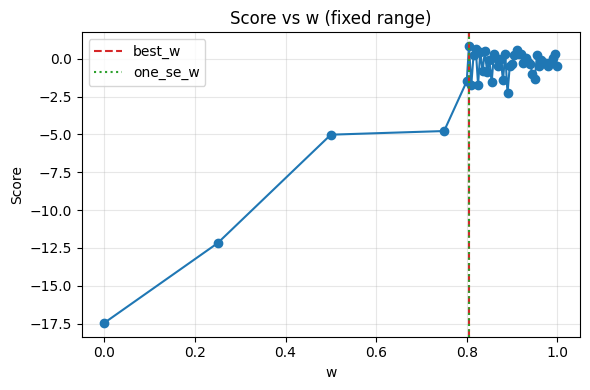

Fixed range -> best_w: 0.805 one_se_w: 0.805


In [42]:
# === Funzione unica refine_grid_search (supporta sia centro dinamico sia intervallo fisso) ===
import json, csv, matplotlib.pyplot as plt
from pathlib import Path

def refine_grid_search(initial_report: dict,
                        base_params: dict,
                        seeds: list,
                        fine_step: float = 0.02,
                        span: float = 0.12,
                        center_mode: str = 'one_se',
                        improve_threshold: float = 0.01,
                        max_refinements: int = 3,
                        weights=None,
                        results_dir: str = 'results_w_search',
                        fixed_range: tuple | None = None,
                        force_recompute_existing: bool = False) -> dict:
    """Raffinamento iterativo dei pesi w.

    Modalità supportate:
    1) Centro dinamico (default): attorno a `one_se_w` (prudente) o `best_w` (center_mode='best') con intervallo
       [center-span, center+span]. Ad ogni livello si esplorano solo i nuovi w (non già testati), con passo `fine_step`.
    2) Intervallo fisso: se `fixed_range=(a,b)` è impostato, OGNI livello esplora esclusivamente la griglia
       uniforme nell'intervallo [a,b] (estremi inclusi) con passo `fine_step`, ignorando `span` e `center_mode`.

    Parametri
    ---------
    initial_report : dict
        Output di `grid_search_w` o di un precedente raffinamento.
    base_params : dict
        Parametri simulazione (passati a `grid_search_w`).
    seeds : list[int]
        Lista seed per la media delle metriche.
    fine_step : float
        Spaziatura della griglia locale (o fissa).
    span : float
        Estensione a sinistra/destra del centro (ignorata se fixed_range non è None).
    center_mode : str
        'one_se' (prudente) o 'best'. Ignorata se fixed_range non è None.
    improve_threshold : float
        Stop se miglioramento relativo del best score < questa soglia.
    max_refinements : int
        Numero massimo di livelli di raffinamento.
    weights : dict | None
        Pesi Score (alpha, beta, gamma, delta, epsilon). Se None usa default.
    results_dir : str
        Cartella per salvare JSON/CSV incrementali.
    fixed_range : (float,float) | None
        Intervallo fisso globale (a,b). Esempio per restringere: (0.8,1.0).
    force_recompute_existing : bool
        Se True riesegue anche i w già presenti (ATTENZIONE: sovrascrive i risultati precedenti con nuove stime).
        Default False: evita ricalcoli e aggiunge solo w nuovi.

    Ritorna
    -------
    dict: {'grid','summary','best_w','best_w_score','one_se_w','weights','history'}.

    Note
    ----
    - I file salvati si chiamano `refine_level{L}.json` e `.csv` (naming uniforme anche per intervallo fisso).
    - `history` contiene i metadati dei livelli (range usato, best score, ecc.).
    - Il calcolo dell'SE del punteggio è approssimato dalla sola componente di varianza di m_retr (dominante).
    """
    Path(results_dir).mkdir(parents=True, exist_ok=True)
    history = []
    prev_best_score = initial_report['best_w_score']
    current_report = initial_report

    for level in range(1, max_refinements+1):
        if fixed_range is not None:
            lo, hi = fixed_range
            lo = max(0.0, min(1.0, lo))
            hi = max(lo, min(1.0, hi))
            candidate_grid = list(np.unique([round(x, 10) for x in np.arange(lo, hi + fine_step/2, fine_step)]))
            center_info = f"range=[{lo:.3f},{hi:.3f}]"
        else:
            center = current_report['one_se_w'] if center_mode == 'one_se' else current_report['best_w']
            lo = max(0.0, center - span)
            hi = min(1.0, center + span)
            candidate_grid = list(np.unique([round(x, 10) for x in np.arange(lo, hi + fine_step/2, fine_step)]))
            center_info = f"center={center:.4f}, span={span:.4f}, interval=[{lo:.3f},{hi:.3f}]"

        tested = set(row['w'] for row in current_report['summary'])
        if force_recompute_existing:
            new_w = candidate_grid  # ricalcola tutto l'intervallo
        else:
            new_w = [w for w in candidate_grid if w not in tested]

        if not new_w:
            print(f"[refine] Nessun nuovo w al livello {level}; stop.")
            break

        print(f"[refine] Livello {level}: {center_info}; nuovi w={new_w}")
        new_report = grid_search_w(base_params, new_w, seeds, weights=weights, verbose=False)

        # Merge risultati
        if force_recompute_existing:
            # Rimuovi eventuali vecchie righe dei w ricalcolati
            filtered_old = [r for r in current_report['summary'] if r['w'] not in new_w]
            merged_rows = filtered_old + new_report['summary']
        else:
            merged_rows = current_report['summary'] + new_report['summary']

        union_grid = sorted({row['w'] for row in merged_rows})
        by_w = {row['w']: row for row in merged_rows}

        # Recompute z-scores sull'unione
        m_vec = [by_w[w]['m_retr'] for w in union_grid]
        fro_vec = [by_w[w]['fro'] for w in union_grid]
        dK_vec = [by_w[w]['deltaK'] for w in union_grid]
        S_vec = [by_w[w]['S_arch'] for w in union_grid]
        G_vec = [by_w[w]['G_ext'] for w in union_grid]
        zm = robust_z(m_vec); zfro = robust_z(fro_vec); zdK = robust_z(dK_vec); zS = robust_z(S_vec); zG = robust_z(G_vec)

        if weights is None:
            weights_loc = dict(alpha=0.5, beta=0.3, gamma=0.1, delta=0.05, epsilon=0.05)
        else:
            weights_loc = weights

        scores = []
        for i, wval in enumerate(union_grid):
            sc = (weights_loc['alpha']*zm[i] - weights_loc['beta']*zfro[i] -
                  weights_loc['gamma']*zdK[i] + weights_loc['delta']*zS[i] +
                  weights_loc['epsilon']*zG[i])
            by_w[wval]['Score'] = sc
            scores.append(sc)

        best_idx = int(np.argmax(scores))
        best_w = union_grid[best_idx]
        best_score = scores[best_idx]
        score_se_approx = {wval: weights_loc['alpha'] * by_w[wval]['m_retr_se'] for wval in union_grid}
        best_se = score_se_approx[best_w]
        candidates = [wval for wval, sc in zip(union_grid, scores) if sc >= best_score - best_se]
        one_se_w = min(candidates)

        current_report = {
            'grid': union_grid,
            'summary': [by_w[wval] for wval in union_grid],
            'best_w': best_w,
            'best_w_score': best_score,
            'one_se_w': one_se_w,
            'weights': weights_loc
        }

        # Salvataggio uniforme
        out_json = Path(results_dir)/f'refine_level{level}.json'
        with open(out_json, 'w') as f:
            json.dump(current_report, f, indent=2)
        out_csv = Path(results_dir)/f'refine_level{level}.csv'
        with open(out_csv, 'w', newline='') as f:
            writer = csv.writer(f)
            header = ['w','Score','m_retr','fro','deltaK','S_arch','G_ext','Score_se_approx']
            writer.writerow(header)
            for wval in union_grid:
                row = by_w[wval]
                writer.writerow([wval, row['Score'], row['m_retr'], row['fro'], row['deltaK'], row['S_arch'], row['G_ext'], score_se_approx[wval]])

        history.append({
            'level': level,
            'best_w': best_w,
            'one_se_w': one_se_w,
            'best_score': best_score,
            'range_used': (lo, hi) if fixed_range is not None else (lo, hi),
            'mode': 'fixed_range' if fixed_range is not None else f'center_{center_mode}',
            'new_w_tested': new_w
        })

        rel_improve = (best_score - prev_best_score) / (abs(prev_best_score)+1e-9)
        print(f"[refine] Livello {level} completato: best_w={best_w:.3f}, one_se_w={one_se_w:.3f}, miglioramento relativo={rel_improve*100:.2f}%")
        if rel_improve < improve_threshold:
            print("[refine] Miglioramento sotto soglia: stop.")
            break
        prev_best_score = best_score

    # Plot finale
    plt.figure(figsize=(6,4))
    scores_plot = [row['Score'] for row in current_report['summary']]
    ws_plot = [row['w'] for row in current_report['summary']]
    order = np.argsort(ws_plot)
    ws_ord = np.array(ws_plot)[order]; sc_ord = np.array(scores_plot)[order]
    plt.plot(ws_ord, sc_ord, 'o-')
    plt.axvline(current_report['best_w'], color='tab:red', ls='--', label='best_w')
    plt.axvline(current_report['one_se_w'], color='tab:green', ls=':', label='one_se_w')
    title = 'Score vs w (fixed range)' if fixed_range else 'Score vs w (refined)'
    plt.xlabel('w'); plt.ylabel('Score'); plt.title(title)
    plt.legend(); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()

    current_report['history'] = history
    return current_report

# Esempi d'uso:
# 1) Raffinamento locale classico
# refined_local = refine_grid_search(report, base_params, seeds, fine_step=0.02, span=0.1)
# 2) Intervallo fisso [0.8,1.0]
refined_fixed = refine_grid_search(report, base_params, seeds, fine_step=0.005, span=0.03, fixed_range=(0.8,1.0), max_refinements=5)
print('Fixed range -> best_w:', refined_fixed['best_w'], 'one_se_w:', refined_fixed['one_se_w'])

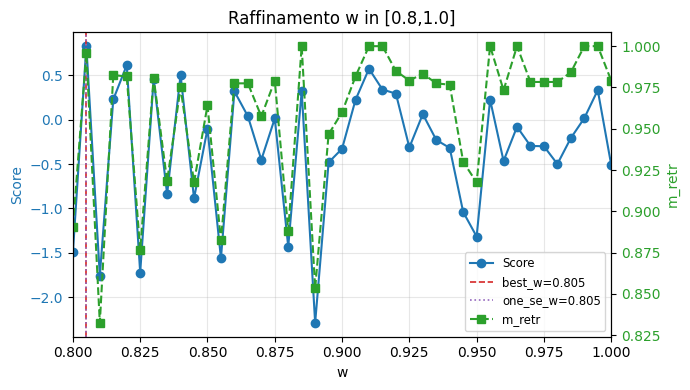

w	Score	m_retr	fro	deltaK
0.800	-1.4941	0.8908	0.2563	14.0
0.805	0.8304	0.9958	0.2482	11.333333333333334
0.810	-1.7576	0.8325	0.2325	10.0
0.815	0.2292	0.9825	0.2652	12.0
0.820	0.6153	0.9817	0.2573	10.333333333333334
0.825	-1.7229	0.8767	0.2596	11.0
0.830	0.4588	0.9808	0.2441	12.666666666666666
0.835	-0.8387	0.9183	0.2577	12.0
0.840	0.5065	0.9750	0.2514	10.666666666666666
0.845	-0.8865	0.9175	0.2584	12.666666666666666
0.850	-0.1019	0.9642	0.2450	13.333333333333334
0.855	-1.5622	0.8825	0.2559	13.0
0.860	0.3209	0.9775	0.2501	11.666666666666666
0.865	0.0405	0.9775	0.2629	13.666666666666666
0.870	-0.4516	0.9575	0.2724	12.0
0.875	0.0155	0.9792	0.2642	13.0
0.880	-1.4319	0.8883	0.2539	12.666666666666666
0.885	0.3237	1.0000	0.2649	13.333333333333334
0.890	-2.2907	0.8533	0.2620	13.0
0.895	-0.4808	0.9467	0.2653	13.0
0.900	-0.3264	0.9600	0.2678	13.0
0.905	0.2248	0.9817	0.2726	11.0
0.910	0.5752	1.0000	0.2690	11.0
0.915	0.3415	1.0000	0.2720	12.666666666666666
0.920	0.2950	0.9850	0.2628	12.6666666666

In [43]:
# === Plot intervallo w in [0.8, 1.0] dai file results_w_search ===
import json, re, os, numpy as np, matplotlib.pyplot as plt
from pathlib import Path

results_dir = Path('results_w_search')
if not results_dir.exists():
    raise FileNotFoundError("Cartella 'results_w_search' non trovata: esegui prima refine_grid_search.")

# Raccogli tutti i file JSON di raffinamento
json_files = sorted(results_dir.glob('refine_level*.json'), key=lambda p: int(re.findall(r'level(\d+)', p.stem)[0]) if re.findall(r'level(\d+)', p.stem) else 0)
if not json_files:
    raise RuntimeError("Nessun file refine_level*.json trovato in results_w_search.")

# Carica ed unisce i summary (l'ultimo file contiene già l'unione, ma uniamo per sicurezza)
summary_map = {}
last_report = None
for jf in json_files:
    with open(jf) as f:
        rep = json.load(f)
    last_report = rep
    for row in rep.get('summary', []):
        summary_map[row['w']] = row  # ultima occorrenza prevale

# Costruisci lista ordinata per w
all_w = sorted(summary_map.keys())
# Filtro intervallo richiesto [0.8,1.0]
ws = [w for w in all_w if 0.8 <= w <= 1.0]
if not ws:
    raise RuntimeError("Nessun w nell'intervallo [0.8,1.0]. Verifica i raffinamenti.")

scores = [summary_map[w]['Score'] for w in ws]
m_retr = [summary_map[w]['m_retr'] for w in ws]
fro = [summary_map[w]['fro'] for w in ws]
deltaK = [summary_map[w]['deltaK'] for w in ws]

best_w = last_report.get('best_w') if last_report else None
one_se_w = last_report.get('one_se_w') if last_report else None

fig, ax1 = plt.subplots(figsize=(7,4))
ax1.plot(ws, scores, 'o-', color='tab:blue', label='Score')
ax1.set_xlabel('w')
ax1.set_ylabel('Score', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.set_xlim(0.8, 1.0)
ax1.grid(alpha=0.3)

# Secondo asse per m_retr
ax2 = ax1.twinx()
ax2.plot(ws, m_retr, 's--', color='tab:green', label='m_retr')
ax2.set_ylabel('m_retr', color='tab:green')
ax2.tick_params(axis='y', labelcolor='tab:green')

# Annotazioni best / one-SE se ricadono nel range
if best_w is not None and 0.8 <= best_w <= 1.0:
    ax1.axvline(best_w, color='tab:red', ls='--', lw=1.2, label=f'best_w={best_w:.3f}')
if one_se_w is not None and 0.8 <= one_se_w <= 1.0:
    ax1.axvline(one_se_w, color='tab:purple', ls=':', lw=1.2, label=f'one_se_w={one_se_w:.3f}')

# Legenda combinata
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(handles1 + handles2, labels1 + labels2, fontsize='small', loc='best')
plt.title('Raffinamento w in [0.8,1.0]')
plt.tight_layout()
plt.show()

# (Opzionale) stampa tabellina sintetica
print('w\tScore\tm_retr\tfro\tdeltaK')
for w, sc, mr, fr, dk in zip(ws, scores, m_retr, fro, deltaK):
    print(f'{w:.3f}\t{sc:.4f}\t{mr:.4f}\t{fr:.4f}\t{dk}')


=== Benchmark w=0.8 seed=0 ===
[seed 0] w=0.800 round 0 total=1.729s
[seed 0] w=0.800 round 0 total=1.729s
[0.96 0.98 0.99]
[0.96 0.98 0.99]
[1.   0.96 0.76 0.96]
[seed 0] w=0.800 round 1 total=2.738s
[1.   0.96 0.76 0.96]
[seed 0] w=0.800 round 1 total=2.738s
[1.   0.63]
[1.   0.63]
[1.   0.61]
[1.   0.61]
[1.   0.75]
[1.   0.75]
[0.89 1.   1.  ]
[0.89 1.   1.  ]
[1. 1. 1.]
[1. 1. 1.]
[0.56 0.63 0.96]
[0.56 0.63 0.96]
[1.   0.99 0.58]
[1.   0.99 0.58]
[0.56 0.91]
[0.56 0.91]
[0.96 1.   0.99 1.  ]
[seed 0] w=0.800 round 2 total=6.590s
[0.96 1.   0.99 1.  ]
[seed 0] w=0.800 round 2 total=6.590s
[0.54 1.  ]
[0.54 1.  ]
[0.99 0.84 1.  ]
[0.99 0.84 1.  ]
[1.   1.   1.   0.63]
[seed 0] w=0.800 round 3 total=3.292s
[1.   1.   1.   0.63]
[seed 0] w=0.800 round 3 total=3.292s
[1. 1.]
[1. 1.]
[0.83 1.   1.  ]
[0.83 1.   1.  ]
[0.63 1.   0.63 0.75]
[seed 0] w=0.800 round 4 total=3.347s

=== Benchmark w=0.8 seed=1 ===
[0.63 1.   0.63 0.75]
[seed 0] w=0.800 round 4 total=3.347s

=== Benchmark w=0

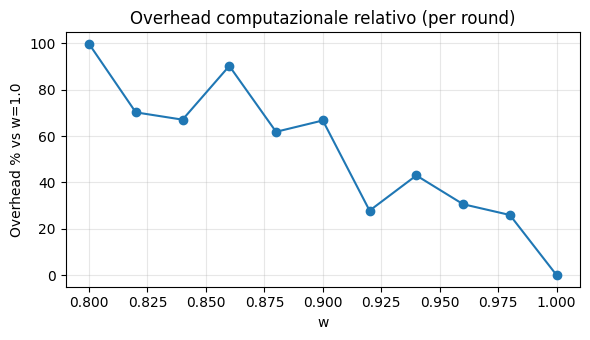

Benchmark salvato in results_w_search_fine\bench_overhead_w.json


In [46]:
# === Benchmark costo computazionale: w in (0.8,1) vs w = 1.0 ===
import time, numpy as np, json, statistics as stats
from copy import deepcopy

# Parametri benchmark (puoi modificare):
w_values_test = np.linspace(0.8, 1.0, 11).tolist() # griglia più fitta da 0.8 a 1.0
benchmark_seeds = [0, 1, 2, 3, 4]  # aumenta per maggiore robustezza
rounds_to_test = 5         # usa subset round per evitare costi eccessivi
show_detail = True         # stampa dettaglio per round

# Useremo gli stessi pattern e dataset per tutti i w per isolare l'effetto del blending
# (Se non disponibili variabili base_params già definite, usare i param correnti.)
L_b = L; K_b = K; N_b = N
M_unsup_b = M_unsup; r_ex_b = r_ex; n_batch_b = min(n_batch, rounds_to_test)
updates_b = up

# Cache dataset per seed
_dataset_cache = {}

def _get_data_for_seed(seed:int):
    if seed in _dataset_cache:
        return _dataset_cache[seed]
    rng = np.random.default_rng(seed)
    xi_true = gen_patterns(N_b, K_b)  # rigeneriamo per ogni seed
    ETA_unsup_loc = gen_dataset_unsup(xi_true, M_unsup_b, r_ex_b, n_batch_b, L_b)
    J_star_loc = JK_real(xi_true)
    _dataset_cache[seed] = (xi_true, ETA_unsup_loc, J_star_loc)
    return _dataset_cache[seed]

# Funzione per calcolare J_unsup medio per layer
def _mean_unsup_J_per_layer(tensor_L_M_N, K):
    L_loc, M_eff_actual, N_loc = tensor_L_M_N.shape
    M_eff_param = max(1, M_eff_actual // K)
    Js = [unsupervised_J(tensor_L_M_N[l], M_eff_param) for l in range(L_loc)]
    return np.sum(Js, axis=0) / L_loc, M_eff_param

# Timed run (ridotto) focalizzato sui passi sensibili a w

def timed_partial_run(w_value: float, seed: int, rounds: int):
    xi_true, ETA_unsup_loc, J_star_loc = _get_data_for_seed(seed)
    timings = { 'round': [], 't_unsup_single': [], 't_unsup_extend': [], 't_hebb_prev': [], 't_blend': [],
                't_propagate': [], 't_disentangle': [], 't_total_round': [] }
    ξr_ref = None
    for b in range(rounds):
        t_round_start = time.perf_counter()
        # 1) estrazione batch
        ETA_round = new_round(ETA_unsup_loc, round=b, collection=False)
        ETA_extend = new_round(ETA_unsup_loc, round=b, collection=True)
        # 2) J_unsup single
        t0 = time.perf_counter(); J_unsup_single, M_eff_round = _mean_unsup_J_per_layer(ETA_round, K_b); t1 = time.perf_counter()
        # 3) J_unsup extend
        J_unsup_extend, M_eff_extend = _mean_unsup_J_per_layer(ETA_extend, K_b); t2 = time.perf_counter()
        # 4) Hebb prev (solo se b>0 e w<1)
        if b == 0:
            t_hebb = 0.0
            J_rec = J_unsup_single.copy()
            J_rec_extend = J_unsup_extend.copy()
        else:
            if (w_value < 1.0) and (ξr_ref is not None):
                tH0 = time.perf_counter()
                J_hebb_prev = unsupervised_J(tf.convert_to_tensor(ξr_ref, dtype=tf.float32), 1)
                tH1 = time.perf_counter(); t_hebb = tH1 - tH0
                # blending
                tB0 = time.perf_counter()
                J_rec = w_value * J_unsup_single + (1 - w_value) * J_hebb_prev
                J_rec_extend = w_value * J_unsup_extend + (1 - w_value) * J_hebb_prev
                tB1 = time.perf_counter(); t_blend = tB1 - tB0
            else:
                t_hebb = 0.0; t_blend = 0.0
                J_rec = J_unsup_single.copy(); J_rec_extend = J_unsup_extend.copy()
        if b == 0 and w_value < 1.0:
            # Anche se w<1 al primo round non abbiamo J_hebb_prev (patterns non ancora estratti) -> t_hebb=0
            t_blend = 0.0
        # 5) propagate
        tP0 = time.perf_counter(); JKS_iter_extend = propagate_J(J_rec_extend, iters=1, verbose=False); tP1 = time.perf_counter()
        # 6) eigenvectors + disentangle (usa cutoff per coerenza)
        tD0 = time.perf_counter()
        vals_ext, vecs_ext = np.linalg.eig(JKS_iter_extend)
        mask_ext = (np.real(vals_ext) > 0.5)
        autov_ext = np.real(vecs_ext[:, mask_ext]).T
        ξr_extend, _ = dis_check(autov_ext, K_b, L_b, J_rec_extend, JKS_iter_extend, ξ=xi_true, updates=updates_b, show_bar=False)
        tD1 = time.perf_counter()
        ξr_ref = ξr_extend  # update
        # tempi
        timings['round'].append(b)
        timings['t_unsup_single'].append(t1 - t0)
        timings['t_unsup_extend'].append(t2 - t1)
        timings['t_hebb_prev'].append(t_hebb)
        timings['t_blend'].append(0.0 if b==0 else (t_blend if w_value < 1.0 else 0.0))
        timings['t_propagate'].append(tP1 - tP0)
        timings['t_disentangle'].append(tD1 - tD0)
        timings['t_total_round'].append(time.perf_counter() - t_round_start)
        if show_detail:
            print(f"[seed {seed}] w={w_value:.3f} round {b} total={timings['t_total_round'][-1]:.3f}s")
    return timings

# Esegue benchmark
all_bench = []
for wv in w_values_test:
    for sd in benchmark_seeds:
        print(f"\n=== Benchmark w={wv} seed={sd} ===")
        t_data = timed_partial_run(wv, sd, rounds_to_test)
        t_data['w'] = wv; t_data['seed'] = sd
        all_bench.append(t_data)

# Aggregazione per w
def agg_metric(wv, key):
    vals = []
    for rec in all_bench:
        if rec['w'] == wv:
            vals.extend(rec[key])
    return np.mean(vals), np.std(vals)

summary_cost = []
for wv in w_values_test:
    m_total, _ = agg_metric(wv, 't_total_round')
    m_hebb, _ = agg_metric(wv, 't_hebb_prev')
    m_blend, _ = agg_metric(wv, 't_blend')
    m_unsup_single, _ = agg_metric(wv, 't_unsup_single')
    m_unsup_extend, _ = agg_metric(wv, 't_unsup_extend')
    summary_cost.append({
        'w': wv,
        'total_round_mean_s': m_total,
        'hebb_mean_s': m_hebb,
        'blend_mean_s': m_blend,
        'unsup_single_mean_s': m_unsup_single,
        'unsup_extend_mean_s': m_unsup_extend
    })

# Trova baseline w=1.0
baseline = next((row for row in summary_cost if abs(row['w'] - 1.0) < 1e-9), None)
if baseline:
    base_total = baseline['total_round_mean_s']
else:
    base_total = None

print("\n=== Sintesi costo medio per round ===")
for row in summary_cost:
    if base_total is not None:
        overhead = (row['total_round_mean_s'] - base_total)/base_total*100 if row['w'] != 1.0 else 0.0
        print(f"w={row['w']:.3f} total={row['total_round_mean_s']:.4f}s hebb={row['hebb_mean_s']:.4f}s blend={row['blend_mean_s']:.4f}s overhead_vs_w=1={overhead:.2f}%")
    else:
        print(f"w={row['w']:.3f} total={row['total_round_mean_s']:.4f}s")

# Stima teorica semplice dell'overhead aggiuntivo per w<1:
# J_hebb_prev richiede outer products delle pattern ricostruite (~O(N * K_eff)), + combinazione due matrici N x N (~O(N^2)).
# Confronto: per w=1 si evita J_hebb_prev e la somma pesata. Se K_eff << N, la parte dominante resta propagate + disentangle.

# Ordinamento e plot overhead
import matplotlib.pyplot as plt
summary_cost_sorted = sorted(summary_cost, key=lambda x: x['w'])
ws_plot = [r['w'] for r in summary_cost_sorted]
overhead_pct = []
if base_total:
    for r in summary_cost_sorted:
        overhead_pct.append(0.0 if r['w']==1.0 else (r['total_round_mean_s']-base_total)/base_total*100)
    plt.figure(figsize=(6,3.5))
    plt.plot(ws_plot, overhead_pct, 'o-')
    plt.xlabel('w'); plt.ylabel('Overhead % vs w=1.0')
    plt.title('Overhead computazionale relativo (per round)')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("Baseline w=1.0 non trovata: impossibile plottare overhead.")

# Output JSON opzionale
benchmark_out_path = Path('results_w_search_fine')/ 'bench_overhead_w.json'
with open(benchmark_out_path, 'w') as f:
    json.dump({'summary': summary_cost, 'baseline_w1_total_round': base_total}, f, indent=2)
print(f"Benchmark salvato in {benchmark_out_path}")